# Import library

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
import cv2
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator

from IPython.display import Image, display
import matplotlib.cm as cm
%matplotlib inline

# Import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#%cd "/content/drive/MyDrive/Academia/Research/Computer Vision/Earthquake_damage_detection/Data"
%cd "/content/drive/My Drive/Study/HonorThesis/"

/content/drive/My Drive/Study/HonorThesis


In [ ]:
df = pd.read_csv (r"Predictors_Linear_regression_columns.csv")

In [ ]:
df

,1111,1112,1113,1121,1122,1123,1131,1132,1133,1211,1212,1213,1221,1222,1223,1231,1232,1233,1311,1312,1313,1321,1322,1323,1331,1332,1333,2111,2112,2113,2121,2122,2123,2131,2132,2133,2211,2212,2213,2221,...,2312,2313,2321,2322,2323,2331,2332,2333,3111,3112,3113,3121,3122,3123,3131,3132,3133,3211,3212,3213,3221,3222,3223,3231,3232,3233,3311,3312,3313,3321,3322,3323,3331,3332,3333,maxDrift,File,Pic ID,Cycle ID,Group
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.180,IMG_0035,IMG_0035.JPG,c7-,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0.180,IMG_0042,IMG_0042.JPG,c7-,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0.180,IMG_1314,IMG_1314.JPG,c7-,1
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.180,IMG_1315,IMG_1315.JPG,c7-,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0.180,IMG_1316,IMG_1316.JPG,c7-,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.024,IMG_1356,IMG_1356.JPG,c24+,28
92,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,2,1,1,0,1,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.027,IMG_0136,IMG_0136.JPG,c25+,29
93,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,1,2,3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.027,IMG_0137,IMG_0137.JPG,c25+,29
94,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,2,1,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3.027,IMG_0139,IMG_0139.JPG,c25+,29


# Import image and data from dataframe

In [ ]:

dataMaxDrift = [] #labels
imageLst = []     
groupName = []    # group to working on kfold

#store value after train
Store_history = []
mae_per_fold = []
Loss_per_fold = []
test_predictions = []
actual_values = []
predict_images = []
store_model = []


Str_path = 'Data4/'
img_height = 180
img_width = 180
numb_epochs = 100

using the dataframe to make a path string then resize image<br>
and append in the list also use dataframe to append data of max drift


In [ ]:

for i in range(df[df.columns[0]].count()):
    #make a path to image
    a = Str_path + str(df['Cycle ID'][i]) + "/" + str(df['Pic ID'][i])
    #read image, resize and add into list
    image = cv2.imread(a)
    image = cv2.resize(image, (img_height, img_width))
    imageLst.append(image)

    #add label value into list
    b = df['maxDrift'][i]
    if b < 0:
        b = abs(b)
    dataMaxDrift.append(b)
    
    #add group name for kFold
    groupName.append(df['Group'][i])

Check lenght, shape of value before training


In [ ]:
groupName = np.array(groupName)
print(len(groupName))

96


In [ ]:
images = np.array(imageLst)

In [ ]:
images.shape

(96, 180, 180, 3)

In [ ]:
dataMaxDrift = np.array(dataMaxDrift)

In [ ]:
len(dataMaxDrift)

96

Prepare for cross validation<br>
Data have: X = images, Y = dataMaxDrift, groups = groupName

In [ ]:
n = 8
gkf = GroupKFold(n_splits = n)
#gkf = KFold(n_splits = n, shuffle=True)

# Grad_cam Function
Source code from:<br> https://keras.io/examples/vision/grad_cam/

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def save_and_display_gradcam(img, heatmap, alpha=0.4):
    # Load the original image
    #img = tf.keras.preprocessing.image.load_img(img_path)
    #img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    #superimposed_img.save(cam_path)

    # Display Grad CAM
    #display(Image(cam_path))
    #display(superimposed_img)
    return superimposed_img

# Attention fuction
Source code from:<br>
https://github.com/EscVM/EscVM_YT/blob/master/Notebooks/0%20-%20TF2.X%20Tutorials/tf_2_visual_attention.ipynb

In [ ]:
# Attention function
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal', 
                              use_bias=True, 
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
            

            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)
            
            return tf.keras.layers.Multiply()([inputs, attention])

In [ ]:
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            
            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention])

# Build CNN layer and train

In [ ]:
count = 1 
for train, test in gkf.split(images, dataMaxDrift, groups = groupName):
    print(f"Start {count} fold with test set data {len(dataMaxDrift[test])}")
    print(f"Group use: {dataMaxDrift[test]}")
    print()
    cnn = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3)),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.3),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.01),
    
    tf.keras.layers.Conv2D(filters=128,    
                           kernel_size=3, 
                           activation='relu'),
  
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2), 

    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),

    ChannelAttention(64, 8),
    SpatialAttention(7),

    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),

    ChannelAttention(64, 8),
    SpatialAttention(7),

    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1, activation = 'linear')])
        
    cnn.compile(optimizer = tf.keras.optimizers.Adam(0.0001), loss = 'mae',
                metrics=['mae'])
    cnn.summary()

    History = cnn.fit(x = images[train] , 
                      y = dataMaxDrift[train] , 
                      validation_data = (images[test] ,dataMaxDrift[test]), 
                      epochs = numb_epochs, 
                      verbose=2)
    
    #Store value after training
    store_model.append(cnn)

    Store_history.append(History)

    scores = cnn.evaluate(images[test], dataMaxDrift[test], verbose=0)
    mae_per_fold.append(scores)
    
    predict_image = images[test]
    predict_images.append(np.array(predict_image))

    test_prediction = cnn.predict(images[test])
    test_predictions.append(np.array(test_prediction))
    
    actual_value = dataMaxDrift[test].copy()
    actual_values.append(np.array(actual_value))
    
    
    print(f"Complete save model {count}")
    
    count = count + 1

Start 1 fold with test set data 12
Group use: [0.193 0.193 0.193 0.193 0.193 0.193 0.193 0.193 0.193 0.193 0.193 0.464]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
random_contrast (RandomContr (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        73792     
_

# Visualization result


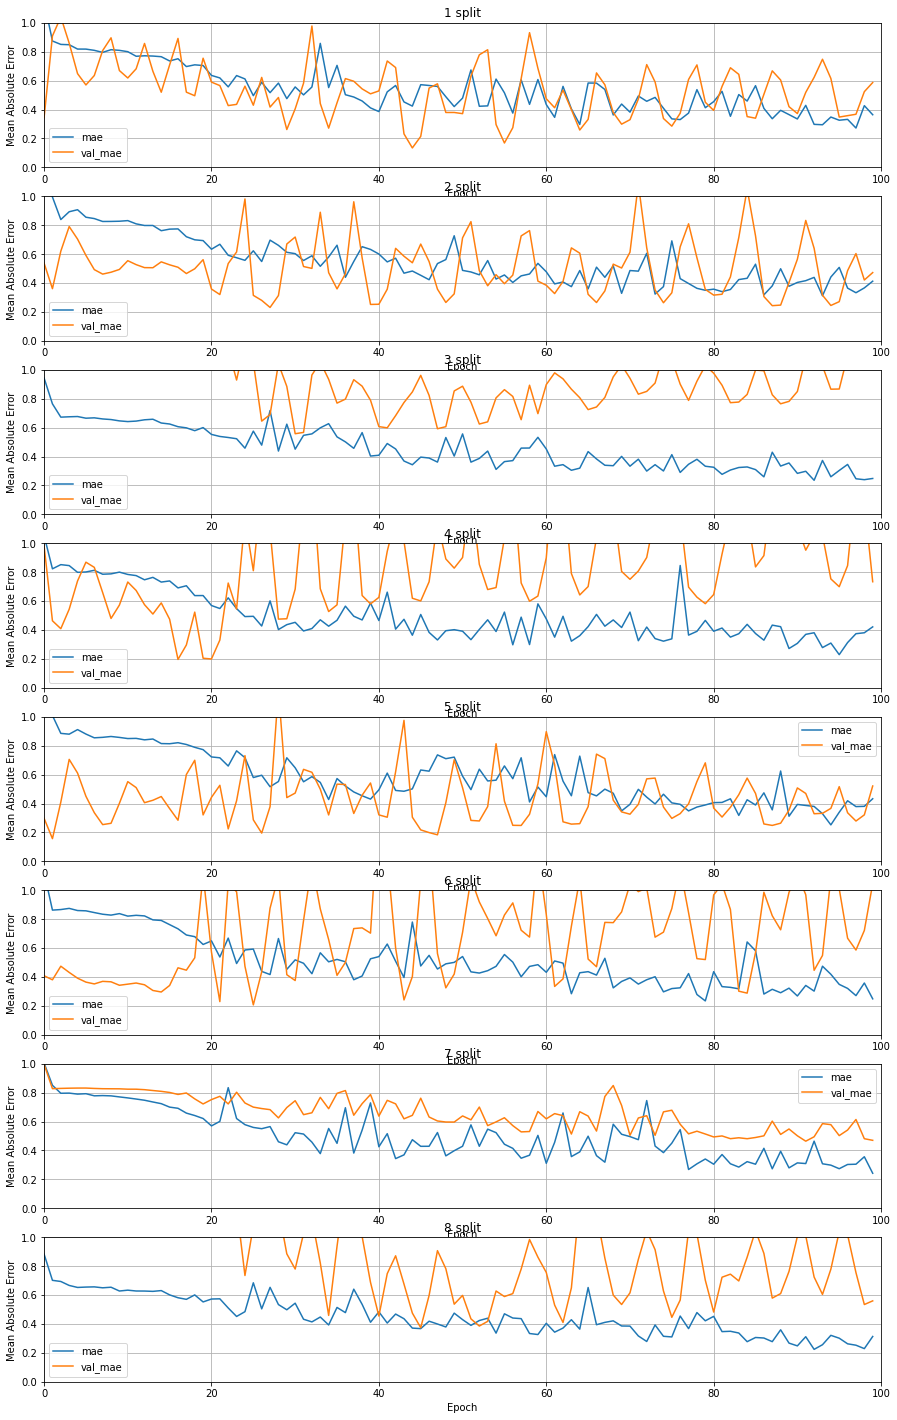

In [ ]:
fig, ax = plt.subplots(figsize=(15,25))
ax.axis("off")
for i in range(n):
     
     plt.subplot(n,1,i+1)
     plt.plot(Store_history[i].history['mae'], label='mae')
     plt.plot(Store_history[i].history['val_mae'], label='val_mae')
     plt.title(f"{i+1} split")
     plt.ylim([0, 1])
     plt.xlim([0,numb_epochs])
     plt.xlabel('Epoch')
     plt.ylabel('Mean Absolute Error')
     plt.legend()
     plt.grid(True)
    

In [ ]:
# Average value of 
sum_avg = 0
for i in Store_history: 
    temp = sum(i.history['mae'])/len(i.history['mae'])
    print(temp)
    sum_avg += temp

0.5403334817290306
0.5552280580997467
0.45481077551841737
0.49796286925673483
0.5800183111429215
0.5159688782691956
0.5036626470088958
0.453181104362011


In [ ]:
sum_val_avg = 0
for i in Store_history:
    temp = sum(i.history['val_mae'])/len(i.history['val_mae'])
    print(temp)
    sum_val_avg += temp

0.5367745512723923
0.5086142154037953
1.0135229623317719
0.8825359444320202
0.4364287006855011
0.689953815639019
0.6617458122968674
0.9784199339151383


In [ ]:
print(mae_per_fold)

[[0.58675616979599, 0.58675616979599], [0.47227445244789124, 0.47227445244789124], [1.0218714475631714, 1.0218714475631714], [0.7339583039283752, 0.7339583039283752], [0.5210527777671814, 0.5210527777671814], [1.0459119081497192, 1.0459119081497192], [0.4702742397785187, 0.4702742397785187], [0.5598034262657166, 0.5598034262657166]]


In [ ]:
test_labels = list(np.concatenate(actual_values).flat)
test_predictions = list(np.concatenate(test_predictions).flat)
test_image = list(np.concatenate(predict_images))

In [ ]:
from sklearn.metrics import  mean_absolute_error

mean_absolute_error(test_labels,test_predictions)

0.6764878619909287

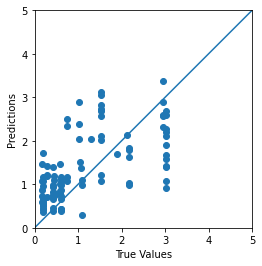

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

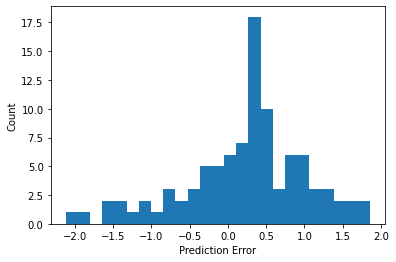

In [ ]:
error = np.array(test_predictions) - np.array(test_labels)
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

# Show image with grad cam

In [ ]:
plt.figure(figsize=(25,100))
j = 0
count_group = 12
a = 3
check = 0
for i in range(96):
    plt.subplot(12,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    if j > 9:
      break
    my_model = store_model[j]

    last_conv = f"conv2d_{a}"
    img_array = test_image[i]
    my_model = store_model[j]

    img_array = img_array.reshape(1,img_height,img_width,3)
    
    count_group = 12

    heatmap = make_gradcam_heatmap(img_array, my_model, last_conv)

    plt.imshow(save_and_display_gradcam(test_image[i], heatmap))
    
    #plt.imshow(test_image[i])
    plt.xlabel("actual: " + "{:.2f}".format(test_labels[i]) + "   predict: " + "{:.2f}".format(test_predictions[i]))
    if check == count_group:
      j +=1
      a += 4
      check = 0
    check += 1
plt.show()

Output hidden; open in https://colab.research.google.com to view.